<a href="https://colab.research.google.com/github/siva4iov/FlatsPrice_DS_Proj/blob/master/Predictions_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictions Visualization

In this notebook I'm going to generate some synthetic data based on dataset, make predictions on new data, and then visualize this predictions on a map

In [177]:
!pip install geopandas
!pip install Shapely
!pip install sdv
!pip install catboost
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
from google.colab import files
if not os.path.exists("/content/kazan.geojson"):
    files.upload()
if not os.path.exists("/content/dataset_clean_full_2.csv"):
    files.upload()
if not os.path.exists("/content/processed_dataset.csv"):
    files.upload()
if not os.path.exists("/content/model"): # trained model
    files.upload()
if not os.path.exists("/content/ct"): # pipeline for normalizing data
    files.upload()

In [153]:
layer = gpd.read_file("kazan.geojson")

In [154]:
df = pd.read_csv("dataset_clean_full_2.csv", sep=";")
p_df = pd.read_csv("processed_dataset.csv")
df.head()

,Living_space,Num_of_rooms,Renovation,Price,Total_area,Kitchen_area,Floor,Appliances_2,Appliances_3,Appliances_4,...,coord,latitude,longitude,district_1,district_2,district_3,district_4,district_5,district_6,district_7
0,20.000000,1,1,27000.0,39.0,12.0,10,1,0,0,...,"(55.7978535, 49.1793271)",55.797854,49.179327,1,0,0,0,0,0,0
1,16.411765,1,1,14000.0,18.0,7.0,9,0,0,0,...,"(55.77585095, 49.1077901578817)",55.775851,49.107790,0,1,0,0,0,0,0
2,75.453998,3,2,40000.0,105.0,25.0,2,1,1,1,...,"(55.731757599999995, 49.169174993589834)",55.731758,49.169175,0,0,1,0,0,0,0
3,13.500000,1,2,20000.0,45.0,17.5,5,1,1,1,...,"(55.816227350000005, 49.13680551681148)",55.816227,49.136806,0,0,0,1,0,0,0
4,24.000000,1,2,22000.0,36.0,6.0,10,1,1,1,...,"(55.8252666, 49.1468802)",55.825267,49.146880,0,0,0,1,0,0,0


# Make a grid based on map

I'm going to visualize mean price in every "box", that will make illustrations more pretty

In [178]:
kazan_polygon = list(layer.geometry[0].geoms)[1]

Functions for creating grid

In [157]:
from shapely.geometry import Polygon
from shapely.prepared import prep


def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx )/delta)
    ny = int((maxy - miny )/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        m_grid = []
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            m_grid.append( poly_ij )
        grid.append(m_grid)
    return np.array(grid).T[::-1, :]


def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta).flatten()))
    return grid

In [158]:
geom = kazan_polygon
grid = partition(geom, 0.03)

## Map with the grid

<AxesSubplot:>

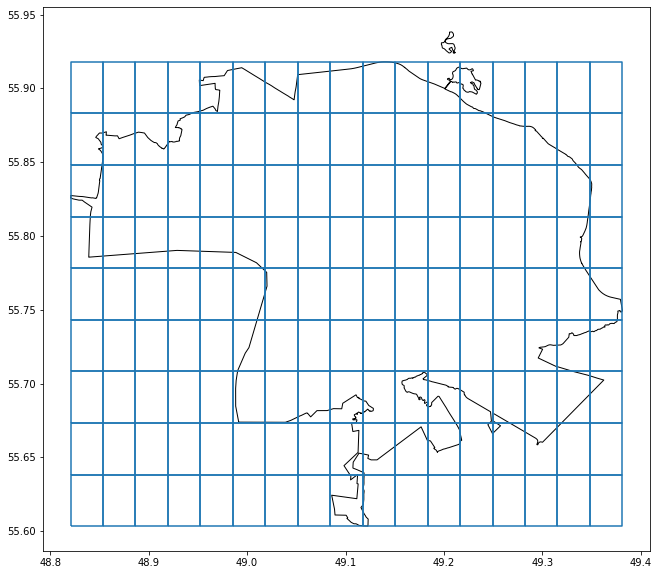

In [180]:
fig, ax = plt.subplots(figsize=(15, 10))
gpd.GeoSeries(grid.flatten()).boundary.plot(ax=ax)
layer.plot(ax = ax, color='white', edgecolor='black', aspect=1.5)
# gen_gdf.plot(ax=ax, alpha=0.5, column='mean_price', cmap="autumn_r", aspect=1.5)
# gdf_p.plot(ax=ax, alpha=0.5, column='mean_price', legend=True, edgecolor="black",linewidth=2, cmap="autumn_r", aspect=1.5)
# markers.plot(ax=ax, marker="*", c="black", aspect=1.5)



## Calculations
Here are functions for calculationg mean values for each "box"(polygon)

In [181]:
from shapely.geometry import Point

def get_points(df):
  points = []
  values = np.concatenate([df.loc[:, ["longitude", "latitude"]].values,
                          df.index.values[np.newaxis].T], axis=1)
  for value in values:
    point = Point(value[0], value[1])
    ind = value[2]
    points.append((point, ind))
  return points

def get_polys(boundaries):
  boundaries = [np.array(value.coords) for value in boundaries]
  polys = [Polygon(value) for value in boundaries]
  return polys

def mean_for_polygon(df, points, polygons):
    mean_for_poly = []
    for polygon in polygons:
      pts_in_poly = [value[1] for value in points if polygon.contains(value[0])]
      means = df.loc[pts_in_poly]["Price"].mean()/1000
      mean_for_poly.append(means)
    return mean_for_poly


In [ ]:
grid_bounds = grid_bounds(geom, 0.03).flatten()

points = get_points(df)
polys = get_polys(gpd.GeoSeries(grid_bounds).boundary)
# I will use size of polygon for generating new data
coords = np.array(list(polys[0].boundary.coords))
poly_width = coords[:,0].max() - coords[:,0].min()
poly_height = coords[:,1].max() - coords[:,1].min()
print(f'Poly width: {poly_width:,.3}')
print(f'Poly height: {poly_height:,.3}')
mean_prices = mean_for_polygon(df, points, polys)
gdf_p = gpd.GeoDataFrame(np.concatenate([np.array(polys)[:, np.newaxis], np.array(mean_prices)[:, np.newaxis]], axis=1),
                         columns=["geometry", 'mean_price'])
gdf_p.loc[:, 'mean_price'] = gdf_p["mean_price"].astype(np.float64)

Poly width: 0.033
Poly height: 0.0349


## Map with mean prices

<AxesSubplot:>

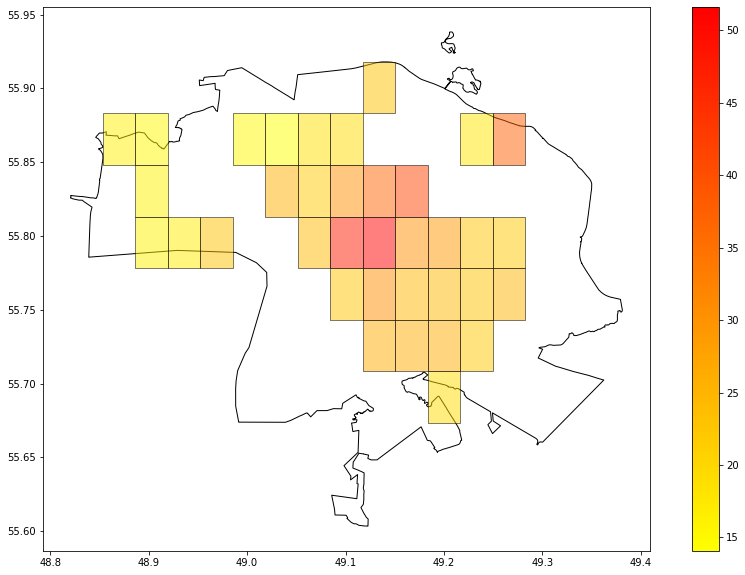

In [184]:
fig, ax = plt.subplots(figsize=(15, 10))
layer.plot(ax = ax, color='white', edgecolor='black', aspect=1.5)
gdf_p.plot(ax=ax, alpha=0.5, column='mean_price', legend=True, edgecolor="black", cmap="autumn_r", aspect=1.5)

I will "expand" this grid a little

My idea is to take polygons which have at least 2 neighbours(left, right, up or down). Take rows from df at this neighbours polygons. Generate df based on this rows, make predictions, and then visualize this data

### Function for calculating distance to metro or city center

In [ ]:
from geopy.distance import geodesic as GD

metro = [
    [55.74437098345888, 49.21842147085857],
    [55.75005848187576, 49.20874803385248],
    [55.759933872926894, 49.19165479076522],
    [55.765435, 49.165143],
    [55.77690597053148, 49.142589131055516],
    [55.787108350131085, 49.122054609493496],
    [55.7959302953497, 49.1062780870964],
    [55.81666978747769, 49.09852469080619],
    [55.82716721066275, 49.08321529204553]
]
metro = np.array(metro)

city_center = [[55.787602, 49.121079]]
city_center = np.array(city_center)


def calc_distances(values: np.ndarray) -> pd.DataFrame:
  distances = []
  min_d = None
  for coords in values:
    for st in metro:
      d = GD(coords, st).km
      if (min_d is None) or d < min_d:
        min_d = d
    cc_d = GD(coords, city_center[0]).km
    distances.append([min_d, cc_d])
    min_d = None
  distances = np.array(distances)
  return pd.DataFrame(distances, columns=["Metro_d", "Center_d"])


# Model for predictions
Uploading trained model, and pipeline from previous notebook.
I will write a function to transform generated dataset to format for model, and then make predictions

In [174]:
import pickle
with open("model", "rb") as file:
  model = pickle.loads(file.read())

with open("ct", "rb") as file:
  ct = pickle.loads(file.read())

ct.fit(p_df)
def make_predictions(df):
  X = ct.transform(df)
  preds = model.predict(X)
  return preds

## Generating data

SDV library for creating synthetic dataset

In [185]:
from sdv.tabular import GaussianCopula
from random import randint

grid = grid_bounds(geom, 0.03)
mean_prices = np.array(mean_for_polygon(df, points, polys)).reshape(grid.shape)

def generate_new_data():
  polys = []
  means = []
  poly_w, poly_h = int(poly_width*10e4), int(poly_height*10e4)
  rows, cols = mean_prices.shape
  
  for i in range(rows):
    for k in range(cols):
      
      if np.isnan(mean_prices[i, k]):
        neighs = []
      
        if i <= rows-2:
          if not np.isnan(mean_prices[i+1, k]):
            neighs.append(grid[i+1, k])
      
        if i >= 1:
          if not np.isnan(mean_prices[i-1, k]):
            neighs.append(grid[i-1, k])
      
        if k <= cols-2:
          if not np.isnan(mean_prices[i, k+1]):
            neighs.append(grid[i, k+1])
      
        if k >= 1:
          if not np.isnan(mean_prices[i, k-1]):
            neighs.append(grid[i, k-1])
      
        if len(neighs) < 2: # not enough neighbours
          continue
        df_rows = []
        for n in neighs:
          df_rows += [value[1] for value in points if n.contains(value[0])]
        if len(df_rows) < 5: # not enough exmaple rows
          continue
        df_sample = df.loc[df_rows].drop(columns=["latitude", "longitude", "Price", 'location', 'coord'])

        model = GaussianCopula()
        model.fit(df_sample)

        generated_df = model.sample(30)
        c_lon, c_lat = list(grid[i, k].centroid.coords)[0]

        latitude = [c_lat + (randint(-poly_h, poly_h)/10e4) for _ in range(30)]
        longitude = [c_lon + (randint(-poly_w, poly_w)/10e4) for _ in range(30)]
        lat_n_lon = np.array([latitude, longitude]).T
        
        distances = calc_distances(lat_n_lon)
        
        generated_df = pd.concat([generated_df, distances], axis=1)
        generated_df.loc[:, "1st_floor"] = (df['Floor'] == 1).astype(np.int8) # feature for predictions 
        generated_df["Price"] = make_predictions(generated_df) # predictions

        polys.append(grid[i, k])
        means.append(generated_df["Price"].mean())

  polys = np.array(polys)
  means = np.array(means, dtype=np.float64)       

  data = np.array([polys, means]).T
  gen_gdf = gpd.GeoDataFrame(data, columns=["geometry", 'mean_price'])
  gen_gdf.loc[:, 'mean_price'] = gen_gdf["mean_price"].astype(np.float64)
  return gen_gdf


gen_gdf = generate_new_data()
markers = gen_gdf.copy()
markers["geometry"] = list(map(lambda x: x.centroid, markers["geometry"]))

<AxesSubplot:>

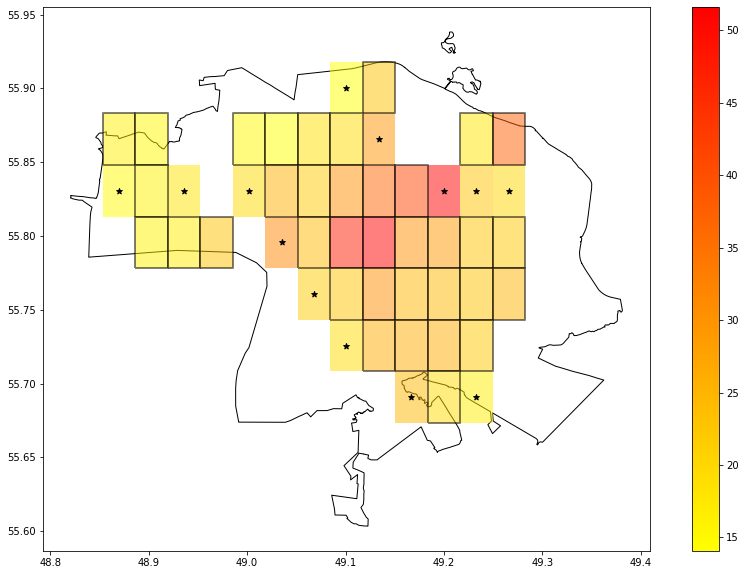

In [186]:
fig, ax = plt.subplots(figsize=(15, 10))
layer.plot(ax = ax, color='white', edgecolor='black', aspect=1.5)
gen_gdf.plot(ax=ax, alpha=0.5, column='mean_price', cmap="autumn_r", aspect=1.5)
gdf_p.plot(ax=ax, alpha=0.5, column='mean_price', legend=True, edgecolor="black",linewidth=2, cmap="autumn_r", aspect=1.5)
markers.plot(ax=ax, marker="*", c="black", aspect=1.5)


In [ ]:
gen_gdf

,geometry,mean_price
0,"POLYGON ((49.08443 55.88297, 49.08443 55.91790...",NaN
1,"POLYGON ((49.11741 55.84803, 49.11741 55.88297...",NaN
2,"POLYGON ((48.85356 55.81309, 48.85356 55.84803...",NaN
3,"POLYGON ((48.91953 55.81309, 48.91953 55.84803...",NaN
4,"POLYGON ((48.98549 55.81309, 48.98549 55.84803...",NaN
5,"POLYGON ((49.18337 55.81309, 49.18337 55.84803...",NaN
6,"POLYGON ((49.21635 55.81309, 49.21635 55.84803...",NaN
7,"POLYGON ((49.24933 55.81309, 49.24933 55.84803...",NaN
8,"POLYGON ((49.01847 55.77816, 49.01847 55.81309...",NaN
9,"POLYGON ((49.05145 55.74322, 49.05145 55.77816...",23.0


In [ ]:
generated_df

,Living_space,Num_of_rooms,Renovation,Total_area,Kitchen_area,Floor,Appliances_2,Appliances_3,Appliances_4,Appliances_5,...,Floors_in_b,district_1,district_2,district_3,district_4,district_5,district_6,district_7,Metro_d,Center_d
0,37.0,3,1,60.0,7.0,4,1,0,0,0,...,7,0,0,0,0,0,0,1,12.193694,16.304408
1,20.0,2,2,43.0,7.0,6,1,0,0,0,...,7,0,0,0,0,0,0,1,5.355058,9.595276
2,16.0,1,1,29.0,5.0,2,0,0,0,0,...,8,0,0,0,0,0,0,1,7.191286,11.024758
3,18.0,1,2,23.0,9.0,8,1,1,0,0,...,9,0,0,0,0,0,0,1,9.960633,14.686749
4,19.0,1,1,38.0,9.0,4,0,1,0,0,...,11,0,0,0,0,0,0,1,7.053313,11.843055
5,26.0,2,1,65.0,11.0,10,1,0,0,0,...,8,0,0,0,0,0,0,1,7.902767,12.525306
6,20.0,1,2,27.0,8.0,1,0,0,1,0,...,9,0,0,0,0,0,0,1,10.079878,14.780226
7,19.0,2,2,49.0,8.0,6,1,0,0,0,...,10,0,0,0,0,0,0,1,5.848636,10.211787
8,32.0,2,1,67.0,11.0,4,0,0,0,0,...,8,0,0,0,0,0,0,1,8.871510,13.192614
9,16.0,1,1,23.0,7.0,2,1,1,0,0,...,8,0,0,0,0,0,0,1,7.686832,12.114010


In [ ]:

poi = Point(48.831349870370365, 55.79)
polys[0].centroid
ar = np.array(list(polys[0].boundary.coords))
width = ar[:, 0].max() - ar[:, 0].min()
height = ar[:, 1].max() - ar[:, 1].min()
width, height

In [ ]:
s = np.array(gpd.GeoSeries(grid).boundary[0].coords)
p1 = Polygon(s)
s = np.array(gpd.GeoSeries(grid).boundary[1].coords)
p2 = Polygon(s)
ts = gpd.GeoDataFrame([[p1,None],
                  [p2,5]], columns=["geometry", 'v'])
v = [[1], [5]]

In [ ]:
coords = np.array(list(map(lambda x:np.array(x.coords), gpd.GeoSeries(grid).boundary.to_list()))).reshape(((210, 2)))

In [ ]:
lat, lon = coords[:, 0], coords[:, 1]

In [ ]:
np.array([1,2,3])[:, np.newaxis]

In [ ]:
df[df["Price"] == -1].mean()